In [ ]:
import os
import numpy as np
import torch
from PIL import Image

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T
from xml.etree import ElementTree

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

#Dataset

In [ ]:
!git clone https://github.com/MominQureshi/DSProject.git

Cloning into 'Data-Scince-Project'...
remote: Enumerating objects: 4422, done.
remote: Counting objects: 100% (4422/4422), done.
remote: Compressing objects: 100% (2285/2285), done.
remote: Total 4422 (delta 2169), reused 4360 (delta 2135), pack-reused 0
Receiving objects: 100% (4422/4422), 53.87 MiB | 32.89 MiB/s, done.
Resolving deltas: 100% (2169/2169), done.


In [ ]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, transforms):
        self.root = '/content/Data-Scince-Project/'
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned

        self.imgs = list(sorted(os.listdir(os.path.join(self.root, "augmented_dataset"))))
        self.masks = list(sorted(os.listdir(os.path.join(self.root, "annotations"))))
        self.labels = ['fname', 'lname', 'country', 'id', 'dob']


    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "augmented_dataset", self.imgs[idx])
        mask_path = os.path.join(self.root, "annotations", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        
        # get bounding box coordinates for each mask
        num_objs = len(self.labels)
        
        # load and parse the file
        tree = ElementTree.parse(mask_path)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = []
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)


        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)


#Model

In [ ]:
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 6  
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
def get_model_instance_segmentation(num_classes):
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    num_classes = 6  # 1 class (person) + background
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

#Train

In [ ]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 6
# use our dataset and defined transformations
dataset = PennFudanDataset(get_transform(train=True))
dataset_test = PennFudanDataset(get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:60])
dataset_test = torch.utils.data.Subset(dataset_test, indices[60:80])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=5, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)


# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")


Epoch: [0]  [ 0/60]  eta: 0:01:18  lr: 0.000090  loss: 2.5213 (2.5213)  loss_classifier: 0.8025 (0.8025)  loss_box_reg: 0.2634 (0.2634)  loss_mask: 1.4265 (1.4265)  loss_objectness: 0.0190 (0.0190)  loss_rpn_box_reg: 0.0099 (0.0099)  time: 1.3121  data: 0.3024  max mem: 3485
Epoch: [0]  [10/60]  eta: 0:00:20  lr: 0.000936  loss: 1.3007 (1.5313)  loss_classifier: 0.3979 (0.4719)  loss_box_reg: 0.2454 (0.2272)  loss_mask: 0.6089 (0.7953)  loss_objectness: 0.0197 (0.0228)  loss_rpn_box_reg: 0.0121 (0.0141)  time: 0.4198  data: 0.0298  max mem: 5081
Epoch: [0]  [20/60]  eta: 0:00:15  lr: 0.001783  loss: 0.7567 (1.1056)  loss_classifier: 0.2221 (0.3319)  loss_box_reg: 0.2002 (0.2106)  loss_mask: 0.2904 (0.5332)  loss_objectness: 0.0146 (0.0176)  loss_rpn_box_reg: 0.0094 (0.0123)  time: 0.3293  data: 0.0035  max mem: 5081
Epoch: [0]  [30/60]  eta: 0:00:11  lr: 0.002629  loss: 0.4705 (0.8935)  loss_classifier: 0.0991 (0.2517)  loss_box_reg: 0.1578 (0.1957)  loss_mask: 0.1970 (0.4204)  loss_ob

In [ ]:
PATH = 'gdrive/DSProject/model/model.h5'
torch.save(model, PATH)

#TEST

In [ ]:
PATH = 'gdrive/DSProject/model/model.h5'
model = torch.load(PATH)

In [ ]:
model = get_model_instance_segmentation(6)
model.eval()

In [ ]:
x = dataset.__getitem__(12)
res = model(x)

<Figure size 432x288 with 0 Axes>

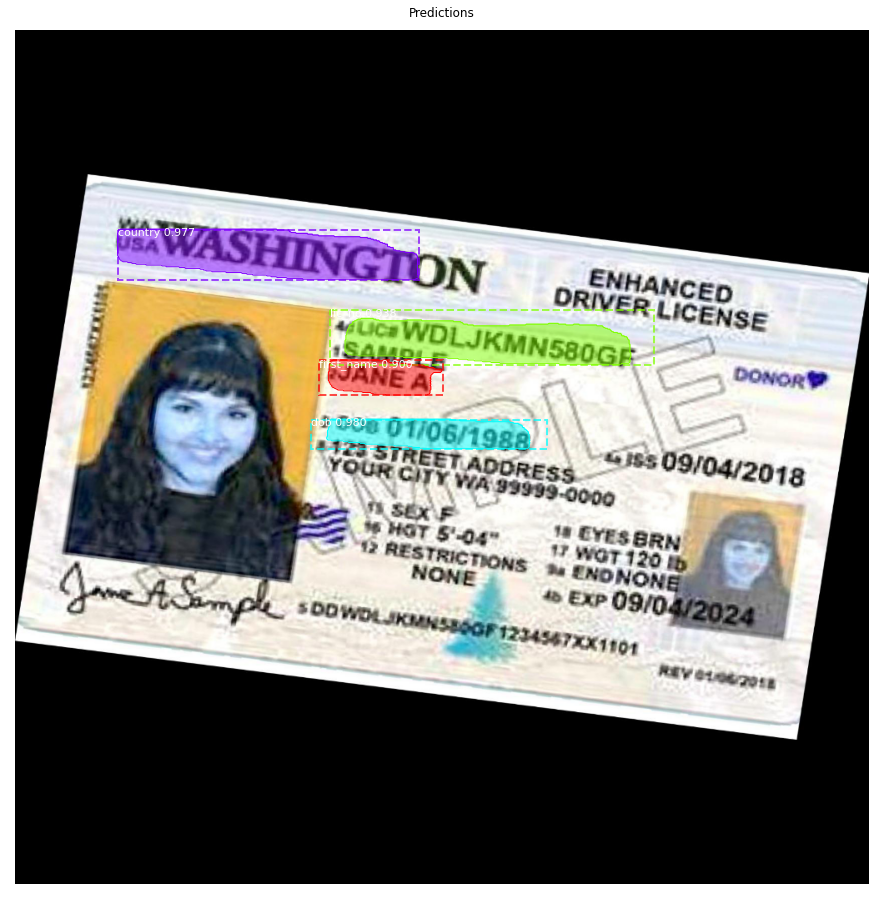

In [ ]:
# load image and get detections
img_path = "/content/Data-Scince-Project/dataset/cnic1.jpg"
img = Image.open(img_path)
detections = res
# Get bounding-box colors
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]
img = np.array(img)
img_size = img.shape[0] * img.shape[1]
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)
pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

classes = ['fname', 'lname', 'country', 'id', 'dob']

if detections is not None:
    n_cls_preds = 5
    bbox_colors = random.sample(colors, n_cls_preds)
    # browse detections and draw bounding boxes
    n = len(detections[0]['boxes'])
    for i in range(n):
        x1, y1, x2, y2 = detections[0]['boxes'][i]
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        color = bbox_colors[int(np.where(
             unique_labels == int(cls_pred))[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h,
             linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=classes[int(cls_pred)], 
                color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
plt.axis('off')
# save image
plt.show()